### Just to check that mapping query cells to reference PCA works as intended

In [1]:
import os
import sys

import numpy as np
import scanpy as sc

In [2]:
sc.settings.verbosity = 1

In [3]:
JUPYTER_DIR = os.path.dirname(os.path.abspath("__file__"))
SYMPHONY_DIR = os.path.dirname(JUPYTER_DIR)
DATA_DIR = os.path.join(SYMPHONY_DIR, "data")
sys.path.append(SYMPHONY_DIR)

import symphonypy as sp

In [4]:
adata = sc.read(os.path.join(DATA_DIR, "PBMC_Satija.h5ad"))
adata

AnnData object with n_obs × n_vars = 17159 × 20729
    obs: 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase'

In [5]:
adata_ref = adata.copy()
adata_query = adata.copy()
n_comps = 20
batch_keys = ["donor"]
raw_counts = True
n_top_genes = 3000

use_genes_column = "highly_variable"

search_highly_variable = (
    use_genes_column == "highly_variable" and "highly_variable" not in adata_ref.var
)

In [6]:
if isinstance(batch_keys, str):
    batch_keys = [
        batch_keys,
    ]

# HVG, PCA
adata_ref.obs["batch_symphonypy"] = (
    (adata_ref.obs[batch_keys]).astype(str).agg("_".join, axis=1)
)

if raw_counts:
    if search_highly_variable:
        sc.pp.highly_variable_genes(
            adata_ref,
            batch_key="batch_symphonypy",
            n_top_genes=n_top_genes,
            flavor="seurat_v3",
        )
    sc.pp.normalize_total(adata_ref, target_sum=1e5)
    sc.pp.log1p(adata_ref)

elif search_highly_variable:
    sc.pp.highly_variable_genes(
        adata_ref, batch_key="batch_symphonypy", n_top_genes=n_top_genes
    )

In [7]:
ref_basis_loadings = "PCs"
query_basis_ref = "X_pca_ref"

# preprocess query
if raw_counts:
    sc.pp.normalize_total(adata_query, target_sum=1e5)
    sc.pp.log1p(adata_query)

In [8]:
sc.pp.scale(adata_ref, zero_center=True, max_value=10)
adata_ref.X[adata_ref.X < -10] = -10
sc.tl.pca(adata_ref, n_comps=n_comps, zero_center=False)

In [9]:
sp._utils._map_query_to_ref(
    adata_ref,
    adata_query,
    query_basis_ref = query_basis_ref,
    ref_basis_loadings=ref_basis_loadings,
    use_genes_column=use_genes_column
)

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


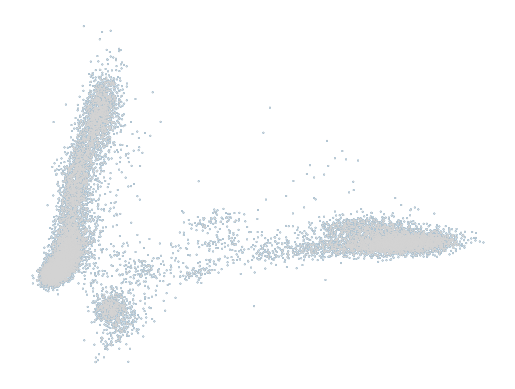

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
adata_query.obs["Reference vs query"] = "query"
sc.pl.embedding(adata_query, basis=query_basis_ref, ax=ax, show=False, color="Reference vs query",
                legend_loc=None, frameon=False)
sc.pl.embedding(adata_ref, basis="X_pca", ax=ax, show=False, frameon=False)
del adata_query.obs["Reference vs query"]
del adata_query.uns["Reference vs query_colors"]

In [11]:
((adata_ref.obsm["X_pca"] - adata_query.obsm[query_basis_ref]) < 1e-3).all()

True

In [12]:
dif = abs(adata_ref.obsm["X_pca"] - adata_query.obsm[query_basis_ref]).flatten()

In [13]:
np.prod(adata_ref.obsm["X_pca"].shape)

343180

In [14]:
(dif > 1e-6).sum()

169643

In [15]:
(dif > 1e-5).sum()

5520

In [16]:
(dif > 1e-4).sum()

1